# Match SDSS+GALEX+WISE with DESY3
--------
<ul>
    <li> <b>SDSS+GALEX+WISE</b>: the sample was queried from: https://salims.pages.iu.edu/gswlc/ <br>
        For more information look at Salim et al. (2016) and  Salim, Boquien & Lee (2018). </li>
    <li> <b> DES Y3</b>: the sample was taken from the hdf5 at Fermilab computers.
<\ull>

In [1]:
import esutil
import numpy as np
import os
import esutil

In [2]:
import matplotlib.pyplot as plt

In [3]:
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import astropy.io.ascii as at

In [4]:
#image path
path = '../graphs/'

# Loading SDSS+GALEX+WISE Sample

In [5]:
fname_sdss = '/data/des61.a/data/johnny/COSMOS/GSWLC-X2.dat'
# at.read(fname_sdss)

In [6]:
names = ['ObjID','GLXID','plate','MJD','fiberID',
         'RA','DEC','z','chisqr','logM','logM_err','logSFR','logSFR_err',
         'Afuv','Afuv_err','Ab','Ab_err','Av','Av_err','flag_sed',
         'UV_survey','flag_uv','flag_midir','flag_mgs']

In [7]:
sdss0 = at.read(fname_sdss, names=names)
print('Sample all size: %i'%(len(sdss0)))

Sample all size: 659229


In [8]:
mask_sdss = (sdss0['DEC']>=-15.)&(sdss0['DEC']<=6.)
sdss = sdss0[mask_sdss]
print('Sample size within eq. plane: %i'%(len(sdss)))
sdss[:5]

Sample size within eq. plane: 143297


ObjID,GLXID,plate,MJD,fiberID,RA,DEC,z,chisqr,logM,logM_err,logSFR,logSFR_err,Afuv,Afuv_err,Ab,Ab_err,Av,Av_err,flag_sed,UV_survey,flag_uv,flag_midir,flag_mgs
int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
1237654879125831915,2429483229262121771,583,52055,216,213.54086,3.45822,0.1792,0.07,11.337,0.038,0.607,0.187,3.633,0.762,0.563,0.12,0.367,0.095,0,2,2,1,1
1237653471443878061,2422657461074796551,457,51901,196,43.210108,-7.915026,0.0782,0.83,10.921,0.018,-1.276,0.272,0.501,0.36,0.101,0.04,0.076,0.031,0,2,2,6,1
1237651753489006620,3383190819236226430,534,51997,175,215.48506,1.939695,0.0777,0.92,10.326,0.062,0.577,0.056,1.372,0.13,0.287,0.075,0.192,0.059,0,3,3,7,1
1237655743488459117,2430855419771487735,2951,54592,70,239.70401,3.962088,0.055,0.69,10.248,0.053,-0.197,0.215,3.64,0.792,0.985,0.16,0.718,0.155,0,2,2,2,1
1237666407916109938,2913901664179072807,400,51820,113,24.1627,-0.029681,0.1562,1.02,10.927,0.019,-1.214,0.657,1.155,0.598,0.186,0.079,0.127,0.053,0,2,2,0,1


In [9]:
# clean big dataset
sdss0 = 0.

# Loading DES Y3

In [10]:
import h5py
path   = '/data/des81.b/data/mariaeli/y3_cats/full/'
fname_des  =     path+'Y3_GOLD_2_2.1_12_3_19.h5'

master = h5py.File(fname_des,'r')
mag_i      = master['catalog/gold/sof_cm_mag_corrected_i'][:][:]
flag_class = master['catalog/gold/extended_class_mash_sof'][:][:]
flag_gold  = master['catalog/gold/flags_gold'][:][:]
dec        = master['catalog/gold/dec'][:][:]
maglim_idx = np.where((dec>=-12.5)&(mag_i<=18.5)&(mag_i>=0.)
                      &(flag_class>=2)&(flag_gold<=8))[0]
master.close()

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
ls /data/des81.b/data/mariaeli/y3_cats/full/

nohup1.out
nohup2.out
sompz_v0.40_08_04_2020.h5*
Y3_GOLD_2_2.1_12_3_19.h5
Y3_GOLD_2_2.1_BPZ_12_3_19.h5
Y3_GOLD_2_2.1_DNF_12_3_19.h5
Y3_GOLD_2_2_1_maps_12_3_19.h5
Y3_GOLD_2_2_1_regions.h5
y3_gold_2.2.1_wide_sofcol_run_redmapper_v0.5.1_redmagic_12_3_19.h5
Y3_mastercat_03_31_20.h5
y3v02-mcal-004-v3_03_16_20.h5


In [12]:
def load_hdf_files(infile,indices,columns,path='catalog/gold/'):
    master = h5py.File(infile,'r')
    gold   = master[path]
    
    mydict = dict().fromkeys(columns)
    mydict['id'] = indices
    for col in columns:
        mydict[col] = gold[col][:][indices]
    master.close()
    return Table(mydict)

In [13]:
columns = ['coadd_object_id','ra','dec','extended_class_mash_sof','flags_gold']
columns+= ['sof_cm_mag_corrected_%s'%(ix) for ix in ['g','r','i','z']]
columns+= ['sof_cm_mag_err_%s'%(ix) for ix in ['g','r','i','z']]

In [14]:
des = load_hdf_files(fname_des,maglim_idx,columns)
print('Sample size: %i'%(len(des)))
des[:5]

Sample size: 466454


sof_cm_mag_corrected_i,sof_cm_mag_err_i,sof_cm_mag_err_g,sof_cm_mag_corrected_g,flags_gold,ra,sof_cm_mag_corrected_z,sof_cm_mag_err_r,sof_cm_mag_err_z,coadd_object_id,dec,extended_class_mash_sof,id,sof_cm_mag_corrected_r
float64,float64,float64,float64,int32,float64,float64,float64,float64,int64,float64,int16,int64,float64
17.926737160627326,0.00873415623871995,0.0077212210810772,18.41796277708244,0,44.9318843342961,17.930797916390073,0.007451060321206684,0.011557008826536904,333407000,0.0771699709121521,3,487,18.177930946019682
16.98233021878081,0.0027048216201074993,0.0022124961296476624,17.400159105751722,0,45.0748532941083,16.884993356957935,0.0020542148263706047,0.003538746715524895,333405907,0.1108993203048,3,832,17.091226631263595
16.87850663087113,0.00392364400464531,0.004087661650421609,17.728132371425655,0,45.0905808215014,16.726703714106467,0.0033619032744842264,0.00479338907924165,333404919,0.136597550261526,3,893,17.180752853575196
18.169988925351493,0.004553640953000537,0.0030601662421158035,18.64912973204329,0,45.107328358285,18.07250825162638,0.0027912013301064284,0.00609623446595045,333404385,0.152365436621655,3,1001,18.291204613289306
17.424381901494094,0.0023207908882593043,0.003638131758754354,18.929733406885884,0,45.019108227181,17.23471022786132,0.0021984091293419197,0.0026827700626765507,333403988,0.163281613643448,3,1205,17.941152244470914


# Sky Match 

Using the latest and fatest code to match sky positions, smatch https://github.com/esheldon/smatch. It's an updated idea of the HTM. <br>

to install:
pip3 install smatch --user or !pip install git+git://github.com/esheldon/smatch

In [15]:
ra1 = np.array(des['ra'])
dec1= np.array(des['dec'])

In [16]:
ra2 = np.array(sdss['RA'])
dec2= np.array(sdss['DEC'])

In [17]:
import smatch

nside=4096 # healpix nside
maxmatch=1 # return closest match

# ra,dec,radius in degrees
matches0 = smatch.match(ra1, dec1, 1./3600, ra2, dec2, nside=nside, maxmatch=maxmatch)

print('Number of Matches: %i'%(len(matches0['i1'])))

Number of Matches: 32544


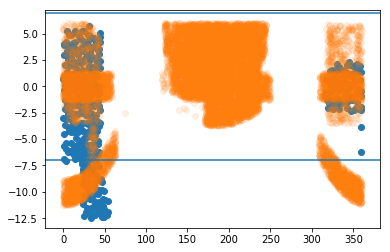

In [18]:
plt.scatter(ra1[::1000],dec1[::1000])
plt.scatter(ra2[::10],dec2[::10],alpha=0.1)
plt.axhline(-7.)
plt.axhline(7.)

In [19]:
dist = (np.arccos(matches0['cosdist'])*180./np.pi)*3600

## eulidean distance works for small offsets not using cos(dec) since it's close to the equator (dec ~ 0)
# dist = np.sqrt((des_matched['RA']-cos_matched['RA'])**2+(des_matched['DEC']-cos_matched['DEC'])**2)*3600

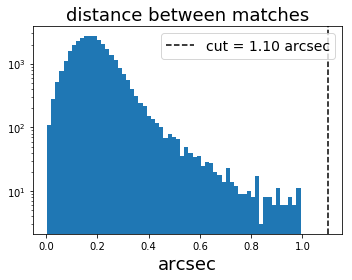

In [20]:
plt.figure(figsize=(5,4))
_ = plt.hist(dist,bins=61)
plt.axvline(1.1,ls='--',color='k',label='cut = %.2f arcsec'%(1.1))
plt.yscale('log')
plt.xlabel('arcsec',fontsize=18)
plt.legend(fontsize=14)
plt.title('distance between matches',fontsize=18)
plt.tight_layout()
# plt.savefig(path+'match_distance.png')

In [21]:
perc = np.linspace(1,99.8,300)
dperc= np.percentile(dist,perc)

Text(0.5,0,'distance [arcesc]')

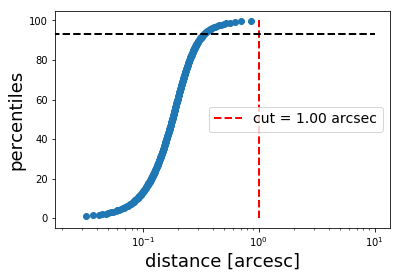

In [22]:
plt.scatter(dperc,perc)
plt.plot([1.,1.],[0,100],'r--',lw=2,label='cut = %.2f arcsec'%(1.0))
plt.plot([0.,10],[93,93],'k--',lw=2,label='_no_')
plt.xscale('log')
plt.legend(fontsize=14)
plt.ylabel('percentiles',fontsize=18)
plt.xlabel('distance [arcesc]',fontsize=18)

In [106]:
sdss['DES'] = False
sdss['DES'][np.unique(matches0['i2'])] = True

des['SDSS'] = False
des['SDSS'][np.unique(matches0['i2'])] = True

In [107]:
np.count_nonzero(sdss['DES'])

32542

In [108]:
matches0['i2']

array([101172,  40432,  62229, ...,  48394,  86656,  97712])

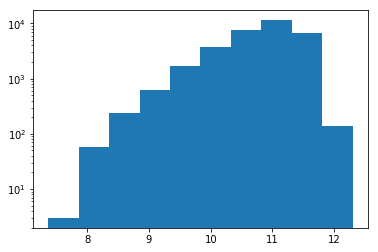

In [117]:
massD = sdss[sdss['DES']]['logM']
zD = sdss[sdss['DES']]['z']
mi = des['sof_cm_mag_corrected_i'][des['SDSS']]

mask = massD >0.
_ = plt.hist(massD[mask])
plt.yscale('log')

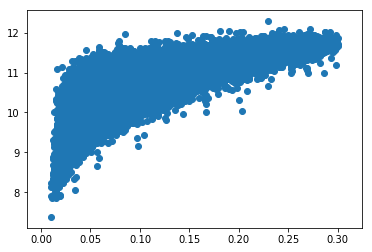

In [116]:
# idx = np.argsort(mi[mask])
plt.scatter(zD[mask],massD[mask])

In [120]:
# save files
fname_out_des = '../data/des_sdss_match.csv'
des[des['SDSS']].write(fname_out_des)

In [121]:
fname_out_des = '../data/sdss_des_match.csv'
sdss[sdss['DES']].write(fname_out_des)

# Completeness: Stripe 82

For this reason, we restrict ourselves for a common are between both dataset, the stripe82.


In [27]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

In [30]:
def compute_fraction_matched(mask,indices):
    return 1.*np.count_nonzero(mask[indices])/len(indices)

In [24]:
nsize = dict()

In [25]:
des_stripe82 = (des['dec']>=-1.26)&(des['dec']<=1.26)
dess = des[des_stripe82]
nsize['des'] = len(dess)

In [26]:
sdss_stripe82 = (sdss['DEC']>=-1.26)&(sdss['DEC']<=1.26)
sdsss = sdss[sdss_stripe82]
nsize['sdss'] = len(sdsss)

In [28]:
mag = np.array(dess['sof_cm_mag_corrected_i'])


In [66]:
dm     = 1./5
mbins  = np.arange(12.0,18.5+dm,dm)
keys,mb= makeBins(mag,mbins)

In [67]:
fm0 = [compute_fraction_matched(dess['SDSS'],idx) for idx in keys]
# fm1 = [compute_fraction_matched(sdsss['DES'],idx) for idx in keys1]

## Sky Figures

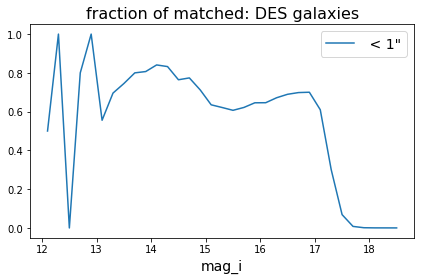

In [68]:
plt.plot(mb,fm0,label=' < 1"')
plt.legend(fontsize=14)
plt.xlabel('mag_i',fontsize=14)
plt.title('fraction of matched: DES galaxies',fontsize=16)
plt.tight_layout()
# plt.savefig(path+'matched_frac_des_gals.png')

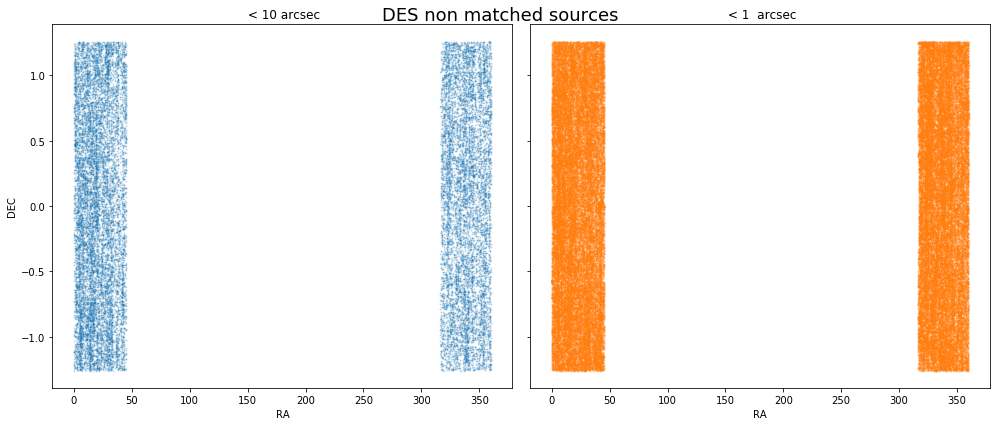

In [69]:
fig, axis = plt.subplots(1, 2, figsize=(14,6), sharex='all',sharey='all')

axis[0].scatter(dess['ra'][dess['SDSS']],dess['dec'][dess['SDSS']],s=1,alpha=0.2)
axis[1].scatter(dess['ra'][~dess['SDSS']],dess['dec'][~dess['SDSS']],s=1,alpha=0.2,color='tab:orange')

axis[1].set_xlabel('RA')
axis[0].set_xlabel('RA')
axis[0].set_ylabel('DEC')

axis[0].set_title(' < 10 arcsec')
axis[1].set_title(' < 1  arcsec')

fig.suptitle('DES non matched sources',fontsize=18)
fig.tight_layout()
# plt.savefig(path+'non_matched_sky_plot.png')

In [71]:
1.*np.count_nonzero(sdsss['DES'])/nsize['sdss']

0.4302788844621514

#### Comments
the DECam psf is ~1", but objects like stars are centroided to 1/10 or 1/00 of the PSF. Location isn’t the problem, deblending noise is the problem, and how objects are grouped into pixels to run the centroid on. Going to scales larger than the PSF is, after the random match background is understood, a study of deblending. Our focus is on a pure, isolated sample of galaxies to test stellar mass computation, so we stay close to the PSF.